In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_filling_half_t_4_em4_rerun_mesh_60_pmap.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

combine results

In [3]:
final_result_old = np.load('u_v1_v2_filling_1_t_4_em4_random_basis_mesh_60_gpu_scaling.npz')


final_ground_state_e_diff_density_old = final_result_old['gse']
final_density_old = final_result_old['d']
final_bond_old = final_result_old['bond']
final_e_difference_old = final_result_old['e_diff']
final_c_difference_old = final_result_old['c_diff']
final_e_fermi_old = final_result_old['e_fermi']
final_iteration_old = final_result_old['iters']
any_bi_fail_old = final_result_old['any_bi_fail']

In [4]:
final_ground_state_e_diff_density = np.concatenate((final_ground_state_e_diff_density, final_ground_state_e_diff_density_old), axis=2)
final_density = np.concatenate((final_density, final_density_old), axis=2)
final_bond = np.concatenate((final_bond, final_bond_old), axis=2)
final_e_difference = np.concatenate((final_e_difference, final_e_difference_old), axis=2)
final_c_difference = np.concatenate((final_c_difference, final_c_difference_old), axis=2)
final_e_fermi = np.concatenate((final_e_fermi, final_e_fermi_old), axis=2)
final_iteration = np.concatenate((final_iteration, final_iteration_old), axis=2)
any_bi_fail = np.concatenate((any_bi_fail, any_bi_fail_old), axis=2)

In [5]:
np.max(final_c_difference)

np.float64(1.566654659257427e-05)

In [6]:
np.max(final_e_difference)

np.float64(9.977559223273147e-09)

In [7]:
np.all(any_bi_fail)==False

np.True_

### Phase Analysis

In [8]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)

In [9]:
from functions_parameters.universal_parameters import phase_1_1, threshold, c_6_uc, c_3_uc, c_2_uc
from functions_parameters.tools import phase_check_nematic_magnetic

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
nematic_measure = np.zeros(u_mesh.shape)
f_phase = np.zeros(u_mesh.shape)
f_measure = np.zeros(u_mesh.shape)
f_max_measure = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
        phase_arr = np.kron(rs_recording,m_recording)
        nematic_measure[i,j] = c6_diff
        f_phase[i,j] = np.argmax(m_recording)
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))
        phase = np.argmax(phase_arr)
        phase_diagram_based_on_d[i,j]=phase

unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_1_1[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

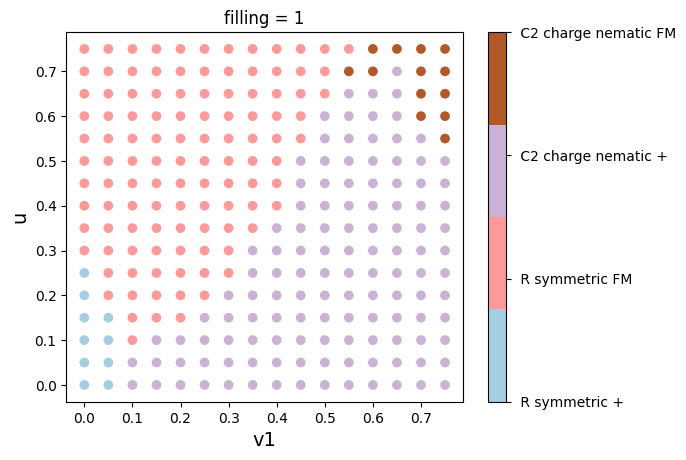

In [10]:
colorbar_ticks_combined = np.arange(len(unique_phase_index))
cmap = plt.get_cmap("Paired", len(unique_phase_index))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

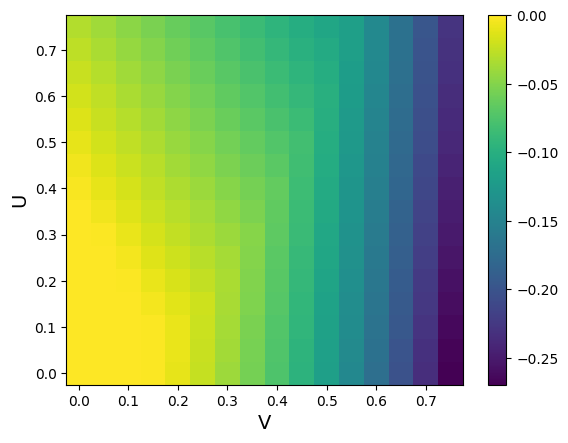

In [11]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

# Obtain a better phase diagram

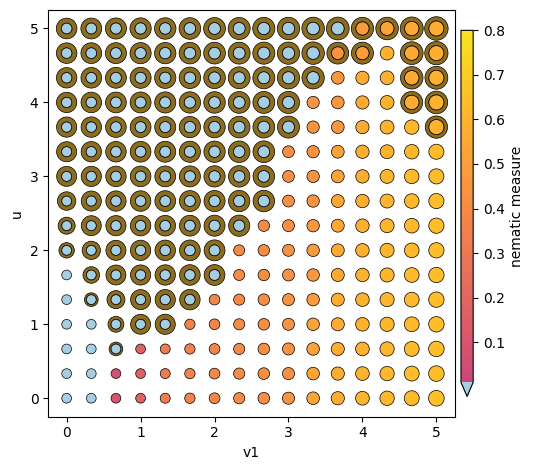

In [25]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

ts_check = np.zeros(u_mesh.shape)
CFG = PlotConfig(nem_vmax=0.8, energy_max=0.7)
fig, ax = plt.subplots(constrained_layout=False)
plot_phase_map(
    fig,
    ax,
    v1_mesh/0.15, u_mesh/0.15,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_box_aspect(1)
ax.set_xlabel("v1")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()

In [13]:
np.max(nematic_measure)

np.float64(0.6476658424651058)

energy is quite large here, actually exceeds the maximum we set.

In [14]:
np.min(sorted_ground_state_e[:,:,0])

np.float64(-0.2697337220362337)

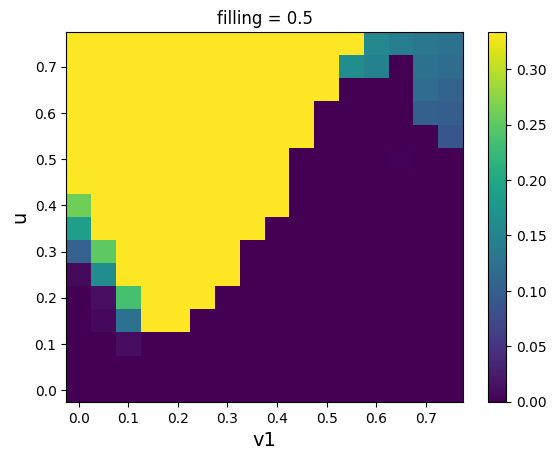

In [15]:
plt.pcolormesh(v1_mesh, u_mesh, f_measure)
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('filling = 0.5')
plt.show()

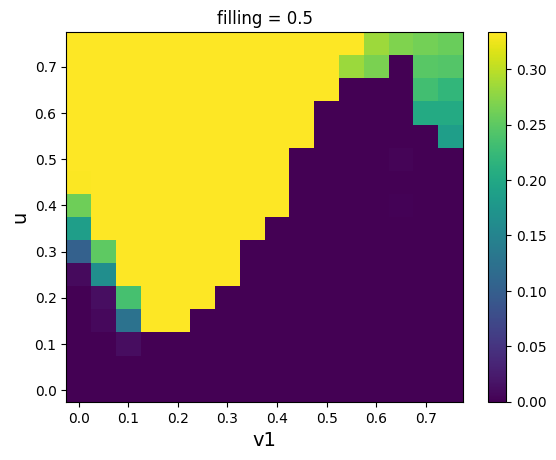

In [16]:
plt.pcolormesh(v1_mesh, u_mesh, f_max_measure)
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('filling = 0.5')
plt.show()

# check the degeneracy

In [17]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
states_index_len = len(states_index[0])
degenerate_state_diagram = -np.ones(final_c_difference.shape, dtype=np.int32)
for index in range(states_index_len):
    i = states_index[0][index]
    j = states_index[1][index]
    k = states_index[2][index]
    d_ij = sorted_density[i,j,k]
    rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.argmax(phase_arr)
    if phase != phase_diagram_based_on_d[i,j] and phase not in degenerate_state_diagram[i,j]:
        degenerate_state_diagram[i,j,k]=phase
    

In [18]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [19]:
degenerate_index

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
         9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
        12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15]),
 array([ 2,  9, 12,  2,  9, 10,  2, 10, 11, 15,  1,  4,  5, 10, 11,  1,  4,
         5, 10, 14, 15,  0,  1,  4,  5,  6, 10, 11, 14,  0,  4,  5,  6, 10,
        12,  4,  5,  6, 10, 12, 13,  4,  5,  6, 10, 11, 12, 13,  4,  5,  6,
        15,  4,  5,  6, 11, 13, 15,  4,  5,  6, 11, 12, 14,  4,  5,  6, 11,
        13,  4,  5,  6, 11, 12, 13,  4,  5,  6,  4,  5,  6]),
 array([13,  2,  9, 13,  2, 14,  6, 15, 11,  2, 13,  1, 13, 14,  5, 14,  1,
         5,  2,  5,  3, 14,  3,  1,  5,  5,  2,  3, 11,  3,  1,  9,  5, 11,
        11,  1,  9,  5, 11, 11, 10,  1, 10,  9,  1,  9,  6,  3,  1, 10,  9,
        10,  1, 10,  9, 11,  4, 13,  1, 

In [20]:
unique_phase_index_degenerate = np.unique(degenerate_state_diagram)
unique_phase_name_degenerate = [phase_1_1[i] for i in np.int_(unique_phase_index_degenerate) if i != -1]

In [21]:
unique_phase_name_degenerate

[' C2 charge nematic FM']

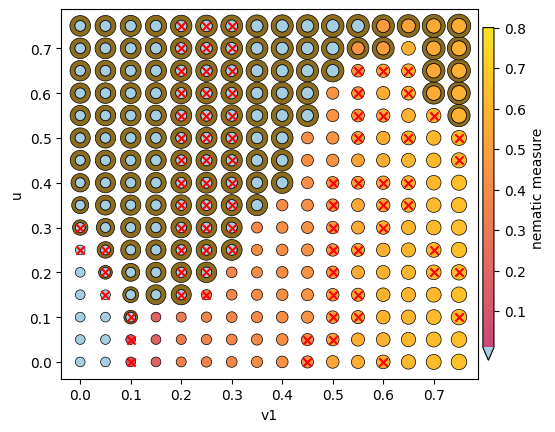

In [22]:
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    v1_mesh, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("v1")
ax.set_ylabel("u")
ax.scatter(v1_arr[degenerate_index[1]], u_arr[degenerate_index[0]], marker='x', color='red', zorder=10)

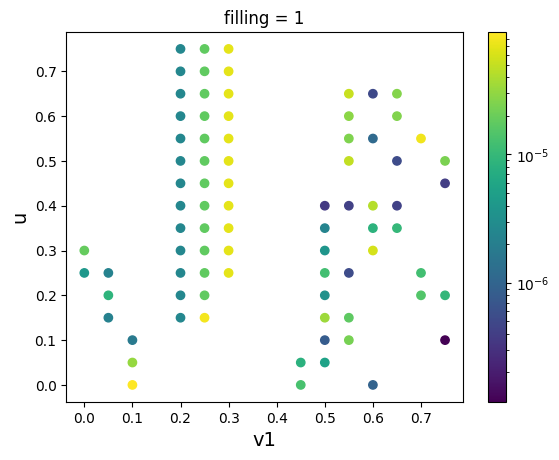

In [23]:
import matplotlib

plt.scatter(v1_arr[degenerate_index[1]], u_arr[degenerate_index[0]], c=sorted_ground_state_e[degenerate_index]-sorted_ground_state_e[degenerate_index[0],degenerate_index[1],0],zorder=10,marker='o',cmap='viridis',norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('filling = 1')
plt.show()

In [24]:
sorted_ground_state_e[degenerate_index]-sorted_ground_state_e[degenerate_index[0],degenerate_index[1],0]

array([8.99155731e-05, 1.30018199e-05, 9.45657367e-07, 3.17939569e-05,
       8.26508641e-06, 5.34658850e-06, 1.79156555e-06, 7.88352249e-07,
       2.31890103e-05, 1.18286329e-07, 2.12876898e-06, 2.53422623e-06,
       8.00794384e-05, 3.43535656e-05, 1.74989512e-05, 8.75038504e-06,
       2.53395289e-06, 1.77890123e-05, 3.30049198e-06, 1.50312425e-05,
       9.46448669e-06, 4.08073656e-06, 2.16010318e-06, 2.53408782e-06,
       1.77886832e-05, 6.78679853e-05, 1.19310385e-05, 5.34040497e-07,
       1.19635104e-05, 1.88015298e-05, 2.53403253e-06, 1.77886475e-05,
       6.78686115e-05, 3.76653040e-06, 5.79179990e-05, 2.53409482e-06,
       1.77891765e-05, 6.78682090e-05, 2.33615246e-06, 8.30978255e-06,
       9.75202303e-06, 2.53382115e-06, 1.77892834e-05, 6.78689336e-05,
       3.61841502e-07, 4.26023756e-07, 4.31388066e-05, 4.42181912e-07,
       2.53410449e-06, 1.77887373e-05, 6.78680516e-05, 3.90452561e-07,
       2.53415433e-06, 1.77893123e-05, 6.78681037e-05, 4.91382393e-05,
      